# **Setup**
 
Reset the Python environment to clear it of any previously loaded variables, functions, or libraries. Then, import the libraries needed to complete the code Professor Melnikov presented in the video.

In [1]:
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS
IS.ast_node_interactivity = "all"    # allows multiple outputs from a cell
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, gensim, nltk, spacy
from collections import Counter
from gensim.models import FastText
from spacy.lang.en import English

np.set_printoptions(linewidth=10000, precision=2, edgeitems=10, suppress=True)
pd.set_option('max_rows', 100, 'max_columns', 1000, 'max_colwidth', 1000, 'precision', 2, 'display.max_rows', 4)
print(f'gensim {gensim.__version__}, numpy {np.__version__}, spacy {spacy.__version__}')

gensim 4.2.0, numpy 1.19.5, spacy 3.4.1


<hr style="border-top: 2px solid #606366; background: transparent;">

# **Review**

In this notebook, you'll practice creating vector representations of sentences and using them to compute similarity among those sentences. 

Start by using `cosine` distance from the `scipy` library, then deduct it from 1 to convert it to cosine similarity. Alternatively, you can also compute it as a dot product of two unit-length vectors.

In [2]:
from scipy.spatial.distance import cosine
# CS = lambda x,y: 1 - cosine(x,y)   # we convert distance to similarity
unit = lambda v: v / (v@v)**0.5      # stretch/shrink vector to make it unit length
CS = lambda x, y: unit(x) @ unit(y)  # cosine similarity is a dot product of standardized vectors

## **Training a FastText Model**

Many pre-trained FastText models are available from Facebook, but the smallest one is ~3GB, so it is slow to load the exercise here.

<details style="margin-top:20px;border-radius:20px">
    <summary>
        <div id="button" style="background-color:#eee;padding:10px;border:1px solid black;border-radius:20px">
            <font color=#B31B1B>▶ </font> 
            File formats for models
        </div>
    </summary>
    <div id="button_info" style="padding:10px">
        These models, which are available for download on the <a href="https://fasttext.cc/docs/en/crawl-vectors.html">fasttext.cc</a> website, are commonly compressed into a zip file in two file formats:
        
<ol>
    <li><b>.vec</b> file is just a text file with a set of word vectors and is very similar to Word2Vec we saw earlier. It can only produce vectors for words in a fixed vocabulary and throws an error for the out-of-vocabulary words. This is basically a dictionary mapping words to their vectors. It cannot be post-trained any further.</li>
    <li><b>.bin</b> file is a binary file containing a pre-trained neural network model, which, when loaded, generates word vectors even for out-of-vocabulary words. It does so by decomposing a query word into subwords (n-grams), computing vectors for each n-gram, and averaging all n-gram vectors into a single vector representation for the queried word. Notably, this model can be post-trained on an additional or more specific corpus.</li>
        </ol>
    </div>
</details>

Thus, you will quickly train your own FastText model instead, with the following steps:
 
1. Find a representative corpus, which is suitable for your NLP problem.
1. Parse the corpus into a list of sentences, which is a list of word tokens.
1. Pass this list of lists of strings to `FastText()` with suitable hyperparameters.
 

### Explore and Preprocess the MSHA Dataset

You will train your FastText model on the Mine Safety and Health Administration (MSHA) corpus. This corpus, which contains brief reports of industrial incidents over a period of 15 years, 2003-2018, is relatively specific and uses a small vocabulary of body parts, injury types, and work settings. Although the quality of the model depends on the amount of training data, you will only use a few thousand of the 177K+ available reports to decrease training time.
 
Load the MSHA dataset, extract `'NARRATIVE'` reports, replace any `NaN` values with an empty string, and lowercase all text to reduce the vocabulary size.

In [3]:
dfAll = pd.read_csv('msha_2003-2018.zip', compression='zip').fillna('')  # replace NaN with empty string
dfAll['INJ_BODY_PART'] = dfAll['INJ_BODY_PART'].apply(lambda s: s.replace('/',', ').replace('(S)','').lower()) # clean up categories
dfAll['NARRATIVE'] = dfAll['NARRATIVE'].str.lower()  # lower case narratives
dfAll['Len'] = dfAll['NARRATIVE'].apply(len)         # narrative's character length
SRaw = dfAll.sort_values('Len', ascending=False).head(10000)['NARRATIVE']  # Pandas Series of 10000 longest narratives
SRaw.to_frame()                                      # display as a dataframe

,NARRATIVE
170698,mechanic was not an employee of the tml pettibone. he was installing the track on a trackhoe after replacing the final drive. the mechanic had a piece of pipe in the rail link fastened to a chain and attached to a fel. the fel was pulling the track back in place. the mechanic was guiging the track over the rollers with the end of the pipe which extended past the track and perpendicular to the track. the weight of the track or some other obstruction caused the pipe to yeild and bend. the fel operator didnot get the signal to stop. the pipe bent. the chain came off the pipe and crushed the mechanics hand.
44521,"ee was transporting an empty ibc bag on forklift. he was holding top of bag w/his left hand against top of rops of forklift. bottom of bag got caught under front tire of forklift. when this ha ppened, the wheel grabbed bag & pulled it out of his hand. as this happened the strap on ibc bag caught his finger as the tension tightened. this caused a laceration & simple fracture to fing"
...,...
170207,"injury was lowering a 400 watt flood light fixture which was attached to the top of a 10' piece of 2"" rigid conduit. after loosening the jamb bolts, and removing the pin that holds the pipe in place; the pipe slid through his hands and before he could stop the pipe and fixture from slamming down it smashed the tips of the two middle fingers on his left hand."
147007,"employee was attempting to trim some skirt rubber from a dump point. employee used pliers in left hand to bend the skirt rubber back to assist in trimming the skirt. with a utility knife in right hand, employee cut away from body. the knife slipped out of the skirt rubber and lacerated the base of left thumb/hand which was slightly out in front of the knife."


Next, tokenize each report into a list of word tokens using [SpaCy](https://spacy.io/usage/spacy-101)'s `nlp()` object.

In [4]:
nlp = English(disable=['tagger', 'parser', 'ner'])  # disabled models save processing time in Spacy
tokenize = lambda text: [t.text.lower() for t in nlp(text)]  # takes a sentences string and produces a list of tokens
STok = SRaw.apply(tokenize)  # Pandas Series of lists of tokens
STok.to_frame()

,NARRATIVE
170698,"[mechanic, was, not, an, employee, of, the, tml, pettibone, ., he, was, installing, the, track, on, a, trackhoe, after, replacing, the, final, drive, ., the, mechanic, had, a, piece, of, pipe, in, the, rail, link, fastened, to, a, chain, and, attached, to, a, fel, ., the, fel, was, pulling, the, track, back, in, place, ., the, mechanic, was, guiging, the, track, over, the, rollers, with, the, end, of, the, pipe, which, extended, past, the, track, and, perpendicular, to, the, track, ., the, weight, of, the, track, or, some, other, obstruction, caused, the, pipe, to, yeild, and, bend, ., the, fel, ...]"
44521,"[ee, was, transporting, an, empty, ibc, bag, on, forklift, ., he, was, holding, top, of, bag, w, /, his, left, hand, against, top, of, rops, of, forklift, ., bottom, of, bag, got, caught, under, front, tire, of, forklift, ., when, this, ha, ppened, ,, the, wheel, grabbed, bag, &, pulled, it, out, of, his, hand, ., as, this, happened, the, strap, on, ibc, bag, caught, his, finger, as, the, tension, tightened, ., this, caused, a, laceration, &, simple, fracture, to, fing]"
...,...
170207,"[injury, was, lowering, a, 400, watt, flood, light, fixture, which, was, attached, to, the, top, of, a, 10, ', piece, of, 2, "", rigid, conduit, ., after, loosening, the, jamb, bolts, ,, and, removing, the, pin, that, holds, the, pipe, in, place, ;, the, pipe, slid, through, his, hands, and, before, he, could, stop, the, pipe, and, fixture, from, slamming, down, it, smashed, the, tips, of, the, two, middle, fingers, on, his, left, hand, .]"
147007,"[employee, was, attempting, to, trim, some, skirt, rubber, from, a, dump, point, ., employee, used, pliers, in, left, hand, to, bend, the, skirt, rubber, back, to, assist, in, trimming, the, skirt, ., with, a, utility, knife, in, right, hand, ,, employee, cut, away, from, body, ., the, knife, slipped, out, of, the, skirt, rubber, and, lacerated, the, base, of, left, thumb, /, hand, which, was, slightly, out, in, front, of, the, knife, .]"


### Train the FastText Model

Next, you'll train the model and save it to a binary file for later retrieval. Saving/loading is convenient, particularly if the model takes hours or days to train. Also, periodically saving the model minimizes the risk of losing the model due to corpus or system errors during training.
<details style="margin-top:20px;border-radius:20px">
    <summary>
        <div id="button" style="background-color:#eee;padding:10px;border:1px solid black;border-radius:20px">
            <font color=#B31B1B>▶ </font> 
            <b>FastText Hyperparameters</b>
        </div>
    </summary>
    <div id="button_info" style="padding:10px">

Use `?FastText` to view and learn about default hyperparameters. Here are some of the key hyperparameters: <br>
        
`vector size` is the dimensionality of the vector embedding. For a large corpus, such as Google News or Wikipedia, you would train a model with larger-size vectors to better capture different relations between words. Choosing the suitable dimension is a combination of art, intuition, experience, and statistics. <br>
 
`workers` is the number of CPUs used for training. You can only use those that are available to us. Codio offers eight CPUs for each Jupyter Notebook instance. Typically, more CPUs results in faster training. 
 
`epochs` is the number of passes through the corpus while the model is learning the embedding vectors. Typically, more is better, but it also may lead to overfitting, where the model simply memorizes the existing associations of words in the corpus and does not generalize to a different text. A larger number of epochs requires more training time.
    </div>
</details>

In [5]:
# train the model with an list (or iterable) of lists of strings
%time ft = FastText(sentences=STok, vector_size=50, workers=8, epochs=10)
# ftmodel.save('msha.bin')                         # save model for later use
# ft = FastText.load('msha.bin')                   # load saved model

CPU times: user 1min 10s, sys: 1.79 s, total: 1min 12s
Wall time: 14 s


## **Evaluate the Trained FastText Model**

Check the resulting vector size.

In [6]:
ft.vector_size

50

`LsVocab` is a list of all word tokens appearing in all narratives of the series `STok`. It is built via a double loop (or list comprehension). The first loop iterates over narratives (each being a list of words) in a series `STok`. The second loop iterates over the words in the given narrative. In essence, it is a flattening (or concatenation) of a container of lists of words into a single large list.

Use the `Counter()` object to identify the top `n` most frequent tokens, which are packed into a Pandas DataFrame `dfVocab` with columns `word` displaying the word string and `freq` displaying the count of the word. The first column is set as the index of the DataFrame.

The ordered DataFrame is displayed horizontally and in color for readability and more effective use of the screen real estate.

Not surprisingly, the most frequent words are punctuation and common stopwords, such as `'the'`, `'to'`, `'and'`, etc.,  which appear often in different parts of text. The words `'ee'` (employee) and `'employee'` also appear often and could potentially be considered a stopword since it may not help in distinguishing different narratives.

In [7]:
LsVocab = [word for sent in STok for word in sent] # flatten list of lists to just a large list of all words
dfVocab = pd.DataFrame(Counter(LsVocab).most_common(n=50), columns=['word','freq']).set_index('word')
dfVocab.T.style.background_gradient(axis=1, cmap='coolwarm')

word,the,.,to,was,a,and,",",on,of,he,his,in,ee,employee,,-,&,with,at,it,that,when,from,left,not,right,for,work,had,back,an,fall,off,up,out,as,this,were,hand,while,by,no,'s,roof,',pain,area,#,"""",into
freq,50555,45068,22645,21619,18375,16155,14243,13552,13265,11993,9942,9727,8613,8425,7558,5212,5015,4485,3902,3657,3594,3590,3534,3384,3355,3103,3090,3060,3056,2937,2679,2577,2532,2514,2473,2438,2435,2413,2290,2223,2159,2116,2060,2026,1952,1918,1871,1843,1795,1748


Now observe the vector for the word `'employee'`, which is a frequent word in this vocabulary.

In [8]:
pd.DataFrame(ft.wv['employee']).T.style.background_gradient(axis=1, cmap='coolwarm')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,-0.73,-0.59,-2.21,0.64,0.60,-0.16,0.53,0.46,0.73,0.06,-0.73,0.26,-0.43,0.75,2.73,-0.09,0.57,1.18,-0.25,0.50,-0.85,-0.16,2.25,2.72,-0.15,0.58,0.12,-0.20,-0.72,0.39,-1.20,-0.32,0.05,-0.25,-0.27,-1.05,1.10,-1.95,-0.00,-1.25,-0.09,0.25,1.33,-1.87,-1.03,2.47,0.08,-1.12,-0.83,0.29


Now observe the resulting vector for the word `'Employeee1'`, which is not in the model's vocabulary.

In [9]:
'Employeee1' in LsVocab   # check if the word is in vocabulary
dfEmployee = pd.DataFrame(ft.wv.most_similar('employee'), columns=['word','CosSim']).set_index('word')
dfEmployee.T.style.background_gradient(cmap='coolwarm', axis=1)

False

word,ee,empl,employer,iee,employment,emp,lee,ie,he,employees
CosSim,0.90,0.90,0.89,0.83,0.74,0.72,0.72,0.71,0.71,0.71


This query word is misspelled but still can be semantically related to `'employee'`. FastText was able to build and reconstruct a reasonable vector representation of the query word. In fact, it learned its relation to `'emp'` and `'ee'`, which were likely used in the same phrases that used `'employee'`.

If a query word is unrelated to the corpus that was used to train the model, then FastText will likely still produce a vector, but of less reliable quality.

In [10]:
'elephant' in LsVocab
dfOOV = pd.DataFrame(ft.wv.most_similar('elephant'), columns=['word','CosSim']).set_index('word')
dfOOV.T.style.background_gradient(cmap='coolwarm', axis=1)

False

word,elevator,elec,elevate,electricity,coolant,electricians,fine,electrical,plant,electrician
CosSim,0.77,0.75,0.73,0.72,0.72,0.72,0.71,0.71,0.70,0.69


The most similar words returned are seemingly unrelated words. The high cosine similarity score is due to a training on a rather small corpus. To have more representative word vectors, you would need a much larger corpus, which demonstrates various attributes of the given query word.

The FastText model can even build a vector for a phrase or a sentence. FastText parses the text into n-grams, ignoring the order of tokens; retrieves n-gram vectors; and computes an average vector, i.e., centroid. 
    
Even though the phrase's n-grams are treated as an order-less bag of n-grams, you can still relate the phrase to other words and phrases semantically. Find words in the model's vocabulary which semantically relate to the given phrase `'fell down'`.

Later, you will learn models that take advantage of the word order, which can make a big difference in semantic meaning. However, FastText is still an important concept, often used in practice because of its simplicity and speed, especially when terabytes of corpora must be processed "fast" and "cheap."

In [11]:
dfOOV = pd.DataFrame(ft.wv.most_similar('fell down'), columns=['word','CosSim']).set_index('word')
dfOOV.T.style.background_gradient(cmap='coolwarm', axis=1)

word,fell,fel,stepped,fellow,dropped,landed,flipped,gripped,ripped,dripped
CosSim,0.87,0.84,0.72,0.72,0.71,0.71,0.68,0.68,0.68,0.67


## **Evaluate Sentence Vectors**

You can generate a sentence vector in at least two ways:
1. As above, feed the full sentence to FastText, which splits the sentence into subwords, generates subword vectors, and computes their average vector, i.e., centroid.
1. Parse the sentence on spaces into word tokens and then average their vectors to compute centroids. 
 
The resulting sentence vectors should be similar but may differ due to differences in subwords.
 
In (1) the subwords may include spaces. For example, the phrase `'fell down the stairs'` has subwords generated on the full sentence, including `'l d'`, `'l do'`, `'ll do'`, `'ll d'`, etc., drawn from the adjacent words. There is a chance that these subwords have vectors in the FastText model. These vectors contribute to centroids.
 
In (2) the phrase `'fell down the stairs'` has four space-separated words with their respective subwords. The subwords with spaces are not considered.

Build these two types of sentence vectors and compare them. Normalize the centroids (to unit length) to make their coefficients comparable.

In [12]:
sQuery = 'fell down the stairs'

def GetSentVec(sSent, m:'FastText model', LsStopwords=[]):
    '''Split the sentence into words and compute the centroid, i.e. average vector'''
    LsWords = nltk.word_tokenize(sSent)
    return np.mean([m.wv[w] for w in LsWords if w in m.wv and not w in LsStopwords], axis=0)

vSent1 =  unit(ft.wv[sQuery])            # sentence vector built from the whole string
vSent2 =  unit(GetSentVec(sQuery, ft))   # sentence vector built from word tokens

print('Centroid vector from word strings', vSent1.round(2)[:10])
print('Centroid vector from full string ', vSent2.round(2)[:10])
print(f'Cosine Similarity: {CS(vSent1, vSent2):.2f}')

Centroid vector from word strings [-0.09 -0.2  -0.04  0.14 -0.22  0.02 -0.08  0.1  -0.19 -0.17]
Centroid vector from full string  [-0.01 -0.17  0.03  0.07 -0.2  -0.01 -0.04  0.09 -0.18 -0.13]
Cosine Similarity: 0.90


It might be easier to compare these sentence vectors in a colored visualization. When juxtaposed, the colors (and even the magnitude) mostly match.

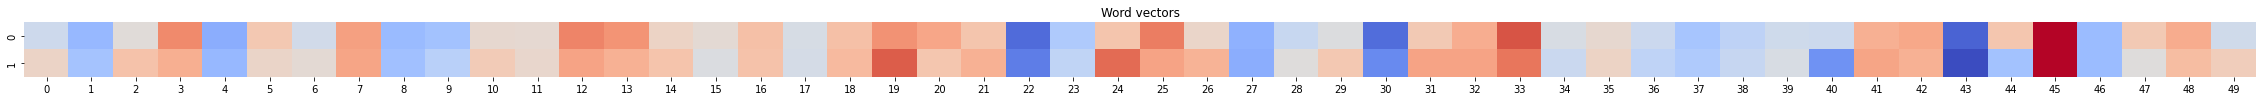

In [13]:
plt.rcParams['figure.figsize'] = [40, 1]   # plot wider figures
ax = sns.heatmap([vSent1, vSent2], annot=False, cmap='coolwarm', cbar=False);
tmp = ax.set_title('Word vectors');

<hr style="border-top: 2px solid #606366; background: transparent;">

# **Optional Practice**

Now, equipped with these concepts and tools, you will tackle a few related tasks.

As you work through these tasks, check your answers by running your code in the *#check solution here* cell, to see if you’ve gotten the correct result. If you get stuck on a task, click the See **solution** drop-down to view the answer.

## Task 1

Compute cosine similarity between phrases `s1='Employee had a hand injury'` and `s2='Work resulted in a wrist fracture'` using a pre-trained `ft` model. 

Do you think the computed cosine similarity is reasonable, or would you expect it to be higher or lower?

<b>Hint:</b> This is similar to how you computed cosine similarity above.

In [ ]:
# check solution here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
<pre>
s1, s2 = 'Employee had a hand injury', 'Work resulted in a wrist fracture'
CS(ft.wv[s1], ft.wv[s2])</pre>

The cosine similarity of ~0.53 is reasonable and indicates a relation, but we can still hope to improve the model and identify stronger relation between two sentences.</details>
</font>
<hr>

## Task 2
 
If you want to improve these sentence vectors, you must train the model on a more appropriate corpus. You can do this by retraining the model on sentences related to hand and wrist injuries. 

First, print the different available injury categories and look at the corresponding counts of narratives.

Then, using these results, note which one(s) are appropriate for training a model related to hand and wrist.

<b>Hint:</b> Try using <code>value_counts()</code> method to compute counts of rows within each category.

In [ ]:
# check solution here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
<pre>
dfAll['INJ_BODY_PART'].value_counts().to_frame().sort_values('INJ_BODY_PART', ascending=False).T</pre>

While there are several categories relating to hands, let's just pick one to start with. Perhaps the most relevant is the "wrist" category.</details>
</font>
<hr>

## Task 3

Create the DataFrame `dfCat` so that it contains just the narratives from the category (or categories) you identified as relevant to hand and wrist injuries in the previous task.

<b>Hint:</b> You can use Boolean masking to filter out irrelevant narratives.

In [ ]:
# check solution here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
<pre>
mask = dfAll['INJ_BODY_PART'].str.lower().str.contains('wrist')
SCat = dfAll[mask].drop_duplicates().sort_values('Len').tail(10000)['NARRATIVE']  # Pandas Series of narrative strings
SCat.to_frame()
    </pre>
    </details> 
</font>
<hr>

# Task 4

Train a FastText model on the narratives in `dfCat` and call the model `ft1`.

<b>Hint:</b> The model training is similar to above, but with a different list of narratives which need to be tokenized.

In [ ]:
# check solution here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
<pre>
%time ft1 = FastText(sentences=SCat.apply(tokenize), vector_size=50)  # train the model
</pre>
</details> 
</font>
<hr>

# Task 5

Compute cosine similarity for the sentences `s1` and `s2` using the new model `ft1`.

<b>Hint:</b> You can compute the cosine similarity as you did above, but with the newly trained model.

In [ ]:
# check solution here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
<pre>
CS(ft1.wv[s1], ft1.wv[s2])
</pre>
</details> 
</font>
<hr>